# Schwab Product Sentiment

The code below is intended to look at the sentiment of Schwab products on Reddit

In [27]:
pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 5.9 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=ffccfa596c146648fbfa853338a59ee232398779211d43835fb6b33c43d01869
  Stored in directory: /Users/kristianmoen/Library/Caches/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
Note: you may need to restart the kernel to use updated packages.


In [29]:
import praw
import pandas as pd
from datetime import datetime
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException




### Project Setup

#### Reddit API and Ticker List Setup

In [30]:
reddit = praw.Reddit(client_id='a2DbaZ7mw-5ufqs_UTl1Tw',
                     client_secret='30bt1R6BffIP6g5pCXr_G8VK8ahBRQ',
                     user_agent='MyAPI/0.0.1')

# Define Schwab tickers keywords
schwab_tickers = [
    # Schwab ETFs
    "SCHB",  # Schwab U.S. Broad Market ETF
    "SCHC",  # Schwab International Small-Cap Equity ETF
    "SCHD",  # Schwab U.S. Dividend Equity ETF
    "SCHE",  # Schwab Emerging Markets Equity ETF
    "SCHF",  # Schwab International Equity ETF
    "SCHO",  # Schwab Short-Term U.S. Treasury ETF
    "SCHP",  # Schwab U.S. TIPS ETF
    "SCHR",  # Schwab Intermediate-Term U.S. Treasury ETF
    "SCHV",  # Schwab U.S. Large-Cap Value ETF
    "SCHX",  # Schwab U.S. Large-Cap ETF
    "SCHG",  # Schwab U.S. Large-Cap Growth ETF
    "SCHM",  # Schwab U.S. Mid-Cap ETF

    # Schwab Mutual Funds
    "SWPPX",  # Schwab S&P 500 Index Fund
    "SWTSX",  # Schwab Total Stock Market Index Fund
    "SFLNX",  # Schwab Fundamental US Large Company Index Fund
    "SFNNX",  # Schwab Fundamental International Large Company Index Fund
    "SWISX",  # Schwab International Index Fund
    "SNXFX",  # Schwab 1000 Index Fund
    "SWSSX",  # Schwab Small-Cap Index Fund
    "SWLGX",  # Schwab U.S. Large-Cap Growth Index Fund
    "SWLVX",  # Schwab U.S. Large-Cap Value Index Fund
    "SWMCX",  # Schwab U.S. Mid-Cap Index Fund
    "SWSCX",  # Schwab U.S. Small-Cap Index Fund
    "SWDSX",  # Schwab Dividend Equity Fund
    "SWHFX",  # Schwab Health Care Fund
    "SWTFX",  # Schwab Technology Fund

    # Schwab Bond Funds
    "SWLBX",  # Schwab Total Bond Market Fund
    "SWIIX",  # Schwab Intermediate-Term Bond Fund
    "SWSBX",  # Schwab Short-Term Bond Fund
    "SWAGX",  # Schwab U.S. Aggregate Bond Index Fund
    "SWRSX",  # Schwab TIPS Fund
    "SWSBX",  # Schwab Short-Term U.S. Treasury Fund

    # Schwab Target Date Funds
    "SWCRX",  # Schwab Target 2020 Fund
    "SWDRX",  # Schwab Target 2025 Fund
    "SWERX",  # Schwab Target 2030 Fund
    "SWFRX",  # Schwab Target 2035 Fund
    "SWGRX",  # Schwab Target 2040 Fund
    "SWHRX"   # Schwab Target 2045 Fund
]


#### Function Setup

In [31]:
# Function to scrape posts mentioning Schwab products
def scrape_reddit_posts(tickers, limit=1000):
    posts = []
    for ticker in tickers:
        for submission in reddit.subreddit('all').search(ticker, limit=limit):
            posts.append({
                'ticker': ticker,
                'title': submission.title,
                'score': submission.score,
                'id': submission.id,
                'url': submission.url,
                'comms_num': submission.num_comments,
                'created': datetime.fromtimestamp(submission.created),
                'body': submission.selftext
            })
    return pd.DataFrame(posts)



# Function to filter for posts that contain Schwab Products
def filter_posts_by_keywords(df, keywords):
    filtered_posts = []
    for _, row in df.iterrows():
        text = row['title'] + ' ' + row['body']
        for keyword in keywords:
            if keyword.lower() in text.lower():
                row['product'] = keyword  # Add the product keyword to the row
                filtered_posts.append(row)
                break  # Stop after finding the first matching keyword
    return pd.DataFrame(filtered_posts)

# Function to get sentiment of post  
def perform_sentiment_analysis(df):
    sid = SentimentIntensityAnalyzer()
    df['sentiment'] = df['body'].apply(lambda text: sid.polarity_scores(text)['compound'])
    return df

# Function to remove non-English posts
def remove_non_english_posts(df):
    def is_english(text):
        try:
            return detect(text) == 'en'
        except LangDetectException:
            return False

### Scrape Posts

In [10]:
df = scrape_reddit_posts(schwab_tickers, limit=1000)

### Apply Sentiment

In [12]:
df = perform_sentiment_analysis(df)


,ticker,title,score,id,url,comms_num,created,body,sentiment
0,SCHB,Thoughts on SCHB?,29,10iics1,https://www.reddit.com/r/Bogleheads/comments/1...,45,2023-01-22 05:14:14,Hello Bogle-friends: \n\nSimple question. What...,0.9660
1,SCHB,SCHB vs VTI,5,1boypgx,https://www.reddit.com/r/ETFs/comments/1boypgx...,9,2024-03-27 04:37:34,"Hello, new to the game. Dumb question but I co...",0.5994
2,SCHB,To fire with SCHB?,3,uiq0si,https://www.reddit.com/r/Fire/comments/uiq0si/...,5,2022-05-04 23:12:48,"Hello all,\n\nI am 26m at my first full time j...",0.8558
3,SCHB,SCHB and what else?,2,18bqauo,https://www.reddit.com/r/ETFs/comments/18bqauo...,13,2023-12-05 16:51:12,I’m looking to invest $100 a month in ETFs. Lo...,0.4199
4,SCHB,SCHB and VTI,0,1aijfbb,https://www.reddit.com/r/Bogleheads/comments/1...,9,2024-02-04 01:43:21,If VTI and SCHB are basically the same. Why no...,0.8295
...,...,...,...,...,...,...,...,...,...
4324,SWFRX,When to use taxable vs tax exempt bonds?,0,32isdx,https://www.reddit.com/r/personalfinance/comme...,8,2015-04-13 21:08:11,I'm in the fortunate position that my wife's f...,0.9607
4325,SWGRX,Choose from limited 403(b) investment options,1,17pvcws,https://www.reddit.com/r/personalfinance/comme...,10,2023-11-07 07:21:34,I just realized my 403(b) is invested 100% in ...,0.9882
4326,SWGRX,"Please help, what should my investment portfol...",0,2wqwrl,https://www.reddit.com/r/portfolios/comments/2...,7,2015-02-22 02:11:31,"Hi Everyone, I'm looking for help with my port...",0.9994
4327,SWHRX,Choose from limited 403(b) investment options,1,17pvcws,https://www.reddit.com/r/personalfinance/comme...,10,2023-11-07 07:21:34,I just realized my 403(b) is invested 100% in ...,0.9882


### Clean Forgin Language

### Group on Ticker

In [13]:
product_sentiment = df.groupby('ticker')['sentiment'].mean().reset_index(name='average_sentiment')

### Plot Average Sentiment 

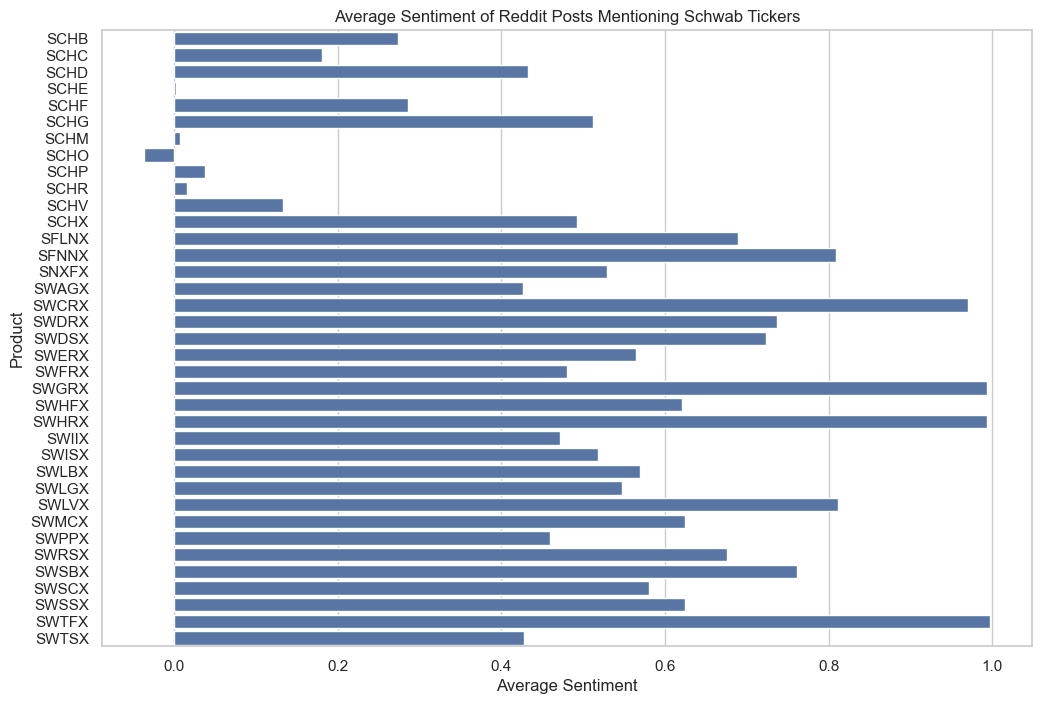

In [16]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='average_sentiment', y='ticker', data=product_sentiment)
ax.set_title('Average Sentiment of Reddit Posts Mentioning Schwab Tickers')
ax.set_xlabel('Average Sentiment')
ax.set_ylabel('Product')
plt.show()



In [17]:
df.to_csv('reddit_posts.csv', index=False)

In [19]:
df_filter = df[df['ticker'] == 'SCHO']
df_filter

,ticker,title,score,id,url,comms_num,created,body,sentiment
1131,SCHO,Private Primary School,5,1c8ryvh,https://www.reddit.com/r/Marikina/comments/1c8...,31,2024-04-20 08:58:02,"Hello, I’m looking for suggestions or recommen...",0.8313
1132,SCHO,Some legend drummed the pornhub intro at my sc...,40202,d7484i,https://v.redd.it/izuogwg9oun31,503,2019-09-20 19:29:10,,0.0000
1133,SCHO,Oida der Standard scho wieder... (Satire),979,12chkty,https://i.redd.it/whx6tcqch3sa1.jpg,146,2023-04-05 05:44:34,,0.0000
1134,SCHO,Billa scho wieder teurer gworden??,144,1d0bhmk,https://www.reddit.com/r/Austria/comments/1d0b...,152,2024-05-25 06:58:50,Kommt mir das nur so vor oder is da scho wiede...,-0.6641
1135,SCHO,YoU wANt a SChoLaRShiP?,20352,czjb2v,https://i.redd.it/yaye3qp37kk31.jpg,147,2019-09-04 05:02:31,,0.0000
...,...,...,...,...,...,...,...,...,...
1363,SCHO,Motzä uf hööchem Nivo. Abr chli meh Ziit fürs ...,58,166atfd,https://i.redd.it/x91bt6jq3glb1.jpg,20,2023-08-31 07:12:35,,0.0000
1364,SCHO,Ernsthaft Tagi? Muen me jetzt scho bewerte wie...,28,1ca867h,https://i.redd.it/v0ar7oohm0wc1.png,13,2024-04-22 05:22:12,,0.0000
1365,SCHO,Bin ja scho a neugierig bub,0,199xt2x,https://i.redd.it/1abrwkwyx8dc1.jpeg,7,2024-01-18 12:02:21,,0.0000
1366,SCHO,auch wenn sie geil ist ! ist scho bischen crin...,56,1bsuwyt,https://v.redd.it/amccaen1tsrc1,2,2024-03-31 22:48:33,,0.0000
